In [1]:
from magma import *
import os
os.environ["MANTLE"] = "coreir"
from mantle.common import FFs

@cache_definition
def DefineShiftRegister(n, init=0, has_ce=False, has_reset=False):
    class _ShiftRegister(Circuit):
        name = 'ShiftRegister_{}_{}_{}_{}'.format(n, init, has_ce, has_reset)
        IO = ['I', In(Bit), 'O', Out(Bit)] + \
               ClockInterface(has_ce, has_reset)
        @classmethod
        def definition(siso):
            ffs = FFs(n, init=init, has_ce=has_ce, has_reset=has_reset)
            reg = braid(ffs, foldargs={"I":"O"})
            reg(siso.I)
            wire(reg.O, siso.O)
            wireclock(siso, reg)
    return _ShiftRegister

In [3]:
# from magma.backend.verilog import compile as compile_verilog
# print(compile_verilog(DefineShiftRegister(2, has_ce=True)))

from magma.backend.coreir_ import compile as compile_coreir

compile_coreir(DefineShiftRegister(2, has_ce=True), "build/DefineShiftRegister.json")
with open("build/DefineShiftRegister.json", "r") as f:
    print(f.read())

{"top":"global.ShiftRegister_2_0_True_False",
"namespaces":{
  "global":{
    "modules":{
      "DFF_init0_has_ceTrue_has_resetFalse":{
        "type":["Record",{
          "I":"BitIn",
          "O":"Bit",
          "CLK":["Named","coreir.clkIn"],
          "CE":"BitIn"
        }],
        "instances":{
          "inst0":{
            "genref":"mantle.reg",
            "genargs":{"has_clr":["Bool",false], "has_en":["Bool",true], "has_rst":["Bool",false], "width":["Int",1]},
            "modargs":{"init":[["BitVector",1],0]}
          }
        },
        "connections":[
          ["inst0.clk","self.CLK"],
          ["inst0.en","self.CE"],
          ["self.I","inst0.in.0"],
          ["self.O","inst0.out.0"]
        ]
      },
      "ShiftRegister_2_0_True_False":{
        "type":["Record",{
          "I":"BitIn",
          "O":"Bit",
          "CLK":["Named","coreir.clkIn"],
          "CE":"BitIn"
        }],
        "instances":{
          "inst0":{
            "modref":"global.DFF_i

In [4]:
from magma.simulator import PythonSimulator
from magma.bit_vector import BitVector

N = 3
ShiftRegisterNCE = DefineShiftRegister(N, has_ce=True)
simulator = PythonSimulator(ShiftRegisterNCE, clock=ShiftRegisterNCE.CLK)
outputs = []
for j in range(2):
    simulator.step()
    simulator.evaluate()
for I, enable in [(1, 1), (0, 1), (1, 1), (0, 1), (1, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1)]:
    simulator.set_value(ShiftRegisterNCE.I, bool(I))
    simulator.set_value(ShiftRegisterNCE.CE, bool(enable))
    for j in range(2):
        simulator.step()
        simulator.evaluate()
        O = simulator.get_value(ShiftRegisterNCE.O)
        CLK = simulator.get_value(ShiftRegisterNCE.CLK)
        outputs.append([O, I, enable, CLK])

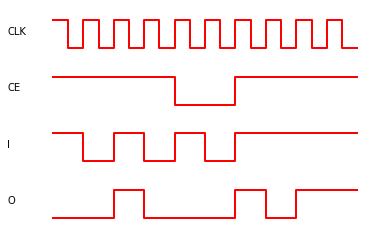

In [5]:
from magma.waveform import waveform

waveform(outputs, ["O", "I", "CE", "CLK"])